In [1]:
import bagpy
from bagpy import bagreader
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy import integrate
import statistics as st
from scipy.signal import butter
from scipy import signal

In [2]:
#reading the rosbag files
bag_1 = bagreader(r'C:\Users\AVISH\OneDrive\Desktop\LAB4\donut.bag')
bag_2 = bagreader(r'C:\Users\AVISH\OneDrive\Desktop\LAB4\boston_mini_tour.bag')

#Reading the messages by topic name
message_1 = bag_1.message_by_topic('/gps')
message_2 = bag_1.message_by_topic('/imu')

message_3 = bag_2.message_by_topic('/gps')
message_4 = bag_2.message_by_topic('/imu')


#Convert to CSV file
dgps1 = pd.read_csv(message_1)
dimu1 = pd.read_csv(message_2)

dgps2 = pd.read_csv(message_3)
dimu2 = pd.read_csv(message_4)

[INFO]  Data folder C:\Users\AVISH\OneDrive\Desktop\LAB4\donut already exists. Not creating.
[INFO]  Data folder C:\Users\AVISH\OneDrive\Desktop\LAB4\boston_mini_tour already exists. Not creating.


# Estimate the Heading (Yaw)

## Magnetometer Calibration:

### Hard Iron correction (HI)

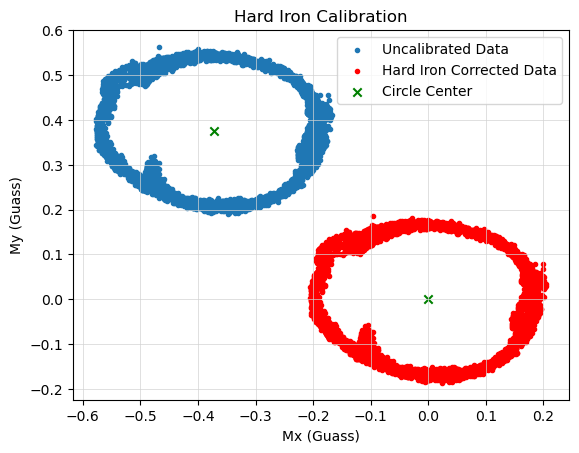

In [3]:
magx = dimu1['mag_field.magnetic_field.x']
magy = dimu1['mag_field.magnetic_field.y']

cx = (max(magx)+min(magx))/2
cy = (max(magy)+min(magy))/2


#Hard Iron correction (HI)
HIx = magx-cx
HIy = magy-cy

ccx = (max(HIx)+min(HIx))/2
ccy = (max(HIy)+min(HIy))/2

plt.grid(color='lightgrey', linestyle='-', linewidth=.5)
plt.scatter(magx, magy, marker='.', label='Uncalibrated Data')
plt.scatter(HIx, HIy, marker='.', color = 'red',label='Hard Iron Corrected Data')
plt.scatter(cx,cy,marker='x',color = 'green',label='Circle Center')
plt.scatter(ccx,ccy,marker='x',color = 'green')
plt.title('Hard Iron Calibration')
plt.xlabel('Mx (Guass)')
plt.ylabel('My (Guass)')
plt.legend()

### SOFT IRON CORRECTION

theta = 29.748095736587274 degrees
sigma =  1.1652494331065761


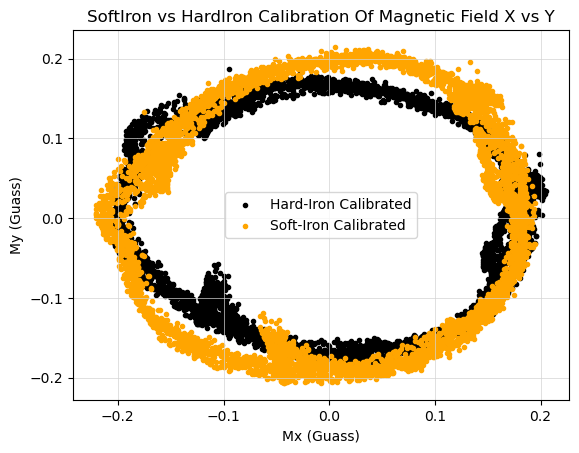

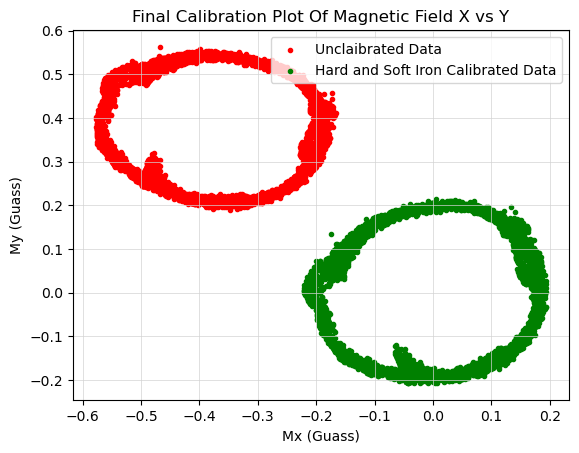

In [6]:
a = (max(HIx)-min(HIx))/2
b = (max(HIy)-min(HIy))/2-.01

# find the major axis along the point that has maximum distance from the center
d = np.zeros([len(HIx),1])
for i in range (len(HIx)):
    d[i]=math.dist([0,0],[HIx[i],HIy[i]])
Dmax=np.amax(d)
Dind=np.where(d==Dmax)
Xmajor = HIx[Dind[0][0]]
Ymajor = HIy[Dind[0][0]]

major_radius = Dmax


theta = np.arcsin(Ymajor/major_radius)
print('theta =',theta*180/math.pi,'degrees')


#Rotate the data by theta
R = [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
v = [HIx, HIy]
rotated_data = np.matmul(R, v)



#Scale the data to fit a circle
sigma = a/b
print('sigma = ', sigma)
scale = [[1, 0], [0, sigma]]
scaled_data = np.matmul(scale, rotated_data)

Calibrated = scaled_data


plt.scatter(HIx, HIy, marker='.', label = 'Hard-Iron Calibrated', color='black')
plt.scatter(Calibrated[0], Calibrated[1], marker='.', label = 'Soft-Iron Calibrated', color='orange')
plt.grid(color='lightgrey', linestyle='-', linewidth=.5)
plt.title('SoftIron vs HardIron Calibration Of Magnetic Field X vs Y')
plt.xlabel('Mx (Guass)')
plt.ylabel('My (Guass)')
plt.legend()
plt.show()




plt.grid(color='lightgrey', linestyle='-', linewidth=.5)
plt.scatter(magx, magy, marker='.', label='Unclaibrated Data', color='red')
plt.scatter(Calibrated[0], Calibrated[1], marker='.', label='Hard and Soft Iron Calibrated Data', color='green')
plt.title('Final Calibration Plot Of Magnetic Field X vs Y')
plt.xlabel('Mx (Guass)')
plt.ylabel('My (Guass)')
plt.legend()
plt.show()

## Sensor Fusion:

In [7]:
def euler_from_quaternion(x, y, z, w):
    
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)
     
        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
        
        roll_x = roll_x*180/math.pi
        pitch_y = pitch_y*180/math.pi
        yaw_z = yaw_z*180/math.pi
     
        return roll_x, pitch_y, yaw_z # in degrees

qx=dimu2['imu.orientation.x']
qy=dimu2['imu.orientation.y']
qz=dimu2['imu.orientation.z']
qw=dimu2['imu.orientation.w']

roll = np.empty((0))
pitch = np.empty((0))
yaw = np.empty((0))


for i in range(len(qx)):
    rollx,pitchy,yawz = euler_from_quaternion(qx[i],qy[i],qz[i],qw[i])

    roll=np.append(roll,rollx)
    pitch=np.append(pitch,pitchy)
    yaw=np.append(yaw,yawz)

    

# Applying Magnetometer Calibration to driving data    
magx = dimu2['mag_field.magnetic_field.x']
magy = dimu2['mag_field.magnetic_field.y']

HIx = magx-cx
HIy = magy-cy

print('theta =',theta*180/math.pi,'degrees')

#Rotate the data by theta
R = [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
v = [HIx, HIy]
rotated_data = np.matmul(R, v)

#Scale the data to fit a circle
sigma = a/b
print('sigma = ', sigma)
scale = [[1, 0], [0, sigma]]
scaled_data = np.matmul(scale, rotated_data)


Calibrated = scaled_data


theta = 29.748095736587274 degrees
sigma =  1.1652494331065761


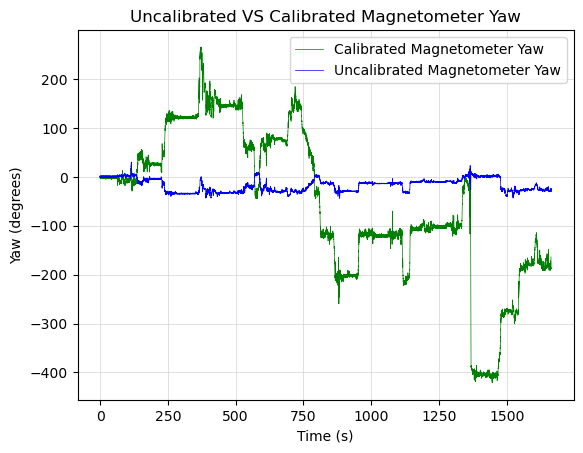

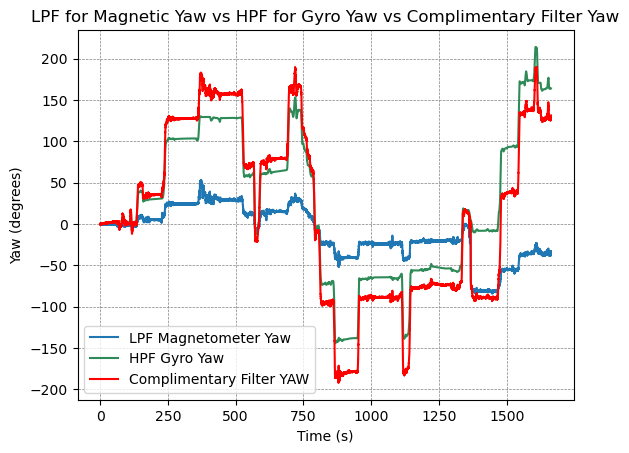

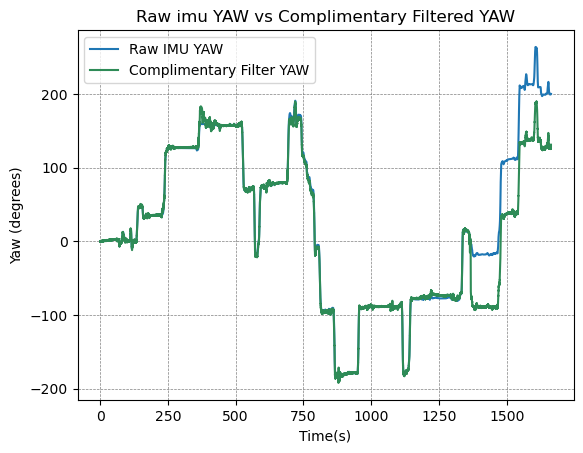

In [8]:
ts = dimu2['header.stamp.secs']
tns = dimu2['header.stamp.nsecs']
time = dimu2['Time']
time = time-min(time)

corrected_yaw_mag = np.arctan2(-Calibrated[1], Calibrated[0])
raw_yaw_mag = np.arctan2(-magy,magx)

YAW = np.unwrap(yaw*math.pi/180)
CORRECTED_YAW_MAG = np.unwrap(corrected_yaw_mag)*180/math.pi
RAW_YAW_MAG = np.unwrap(raw_yaw_mag)*180/math.pi

plt.grid(color='lightgrey', linestyle='-', linewidth=.5)
plt.plot(time,CORRECTED_YAW_MAG-CORRECTED_YAW_MAG[0], label='Calibrated Magnetometer Yaw', color='green',linestyle='-', linewidth=.5)
plt.plot(time,RAW_YAW_MAG-RAW_YAW_MAG[0], label='Uncalibrated Magnetometer Yaw', color='blue',linestyle='-', linewidth=.5)
plt.title('Uncalibrated VS Calibrated Magnetometer Yaw')
plt.xlabel('Time (s)')
plt.ylabel('Yaw (degrees)')
plt.legend()
plt.show()

#Integrate Gyro 
gyroz = dimu2['imu.angular_velocity.z']
yaw_gyro = integrate.cumtrapz(gyroz, time, initial=0)*180/math.pi


## Complimantary Filtering
alpha = 0.8

HPF= alpha*yaw_gyro
LPF = (1-alpha)*CORRECTED_YAW_MAG
CF = HPF+LPF

plt.grid(color='grey', linestyle='--', linewidth=.5)
plt.plot(time,LPF-LPF[0],label='LPF Magnetometer Yaw')
plt.plot(time,HPF-HPF[0], label = 'HPF Gyro Yaw', color='seagreen')
plt.plot(time,CF-CF[0], label = 'Complimentary Filter YAW', color='red')
plt.title('LPF for Magnetic Yaw vs HPF for Gyro Yaw vs Complimentary Filter Yaw')
plt.xlabel('Time (s)')
plt.ylabel('Yaw (degrees)')
plt.legend()
plt.show()

plt.grid(color='grey', linestyle='--', linewidth=.5)
plt.plot(time,(YAW-YAW[0])*180/math.pi, label='Raw IMU YAW')
plt.plot(time,CF-CF[0], label = 'Complimentary Filter YAW', color='seagreen')
plt.title('Raw imu YAW vs Complimentary Filtered YAW')
plt.xlabel('Time(s)')
plt.ylabel('Yaw (degrees)')
plt.legend()
plt.show()

# Estimate Forward Velocity

## GPS Position Derivative

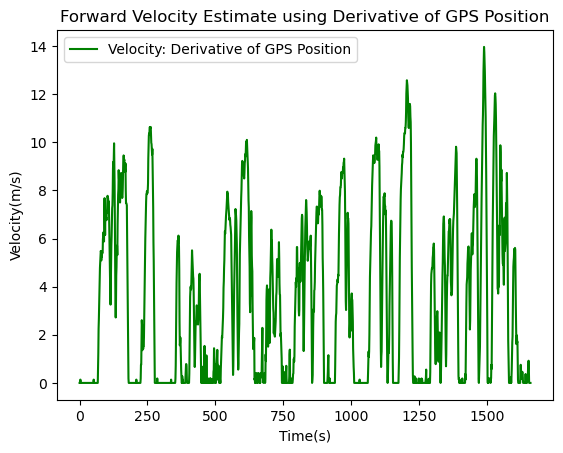

In [9]:
t = dgps2['Header.stamp.secs']
t = t - min(t)

UTM_east = dgps2['UTM_easting']
UTM_north = dgps2['UTM_northing']


GPS_dist = np.empty((0))
dt = np.empty((0))
for i in range(len(t)-1):
    dist = np.sqrt(np.square(UTM_east[i+1]-UTM_east[i])+np.square(UTM_north[i+1]-UTM_north[i]))
    GPS_dist = np.append(GPS_dist,dist)
    
    diff = t[i+1]-t[i]
    dt = np.append(dt,diff)

GPS_velocity = GPS_dist/dt

plt.plot(GPS_velocity,label='Velocity: Derivative of GPS Position', color='green')
plt.title('Forward Velocity Estimate using Derivative of GPS Position')
plt.xlabel('Time(s)')
plt.ylabel('Velocity(m/s)')
plt.legend()
plt.show()

## Linear Accelaration Integral

In [11]:
def adj(vel):
    end=[]
    start=[]
    start.append(0)
    difference=[]
    difference=np.append(difference,0)
    ind=[]
    
    for i in range (len(vel)-1):
        difference = np.append(difference,vel[i+1]-vel[i])
    
    for n in range (len(difference)-1):
        if difference[n] == 0:
            if difference[n+1]!=0:
                end.append(n)        
        else:
             if difference[n+1] == 0:
                start.append(n+1)
                
    for k in range (len(end)):
        if (end[k] - start[k]) > 40*5:
            ind.append([start[k],end[k]])
            
    for m in range (len(ind)):
        s = ind[m][0]
        e = ind[m][1]
        vel[s:]=vel[s:]-st.mean(vel[s:e])
    return vel

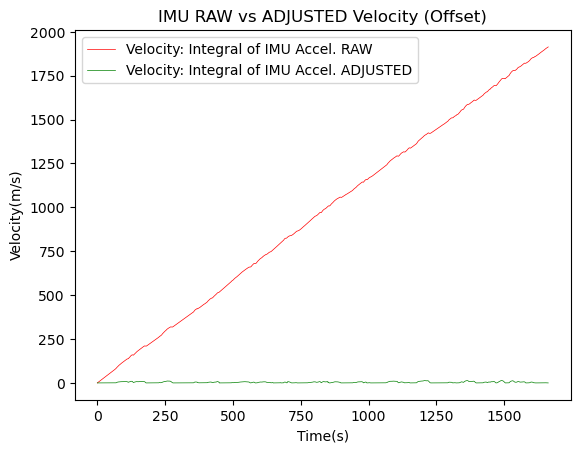

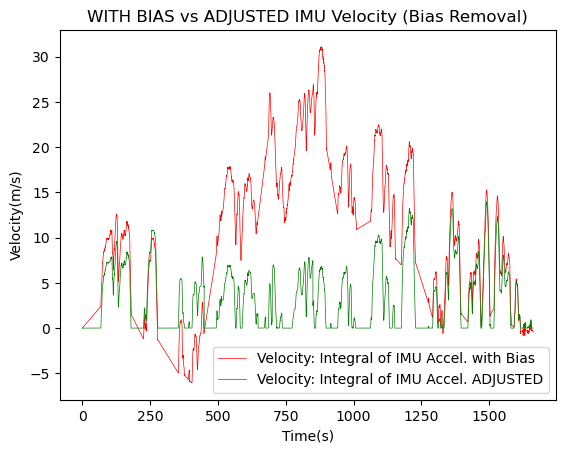

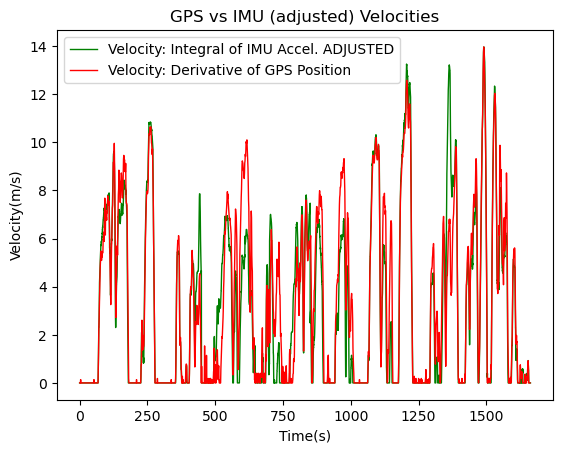

In [16]:
ax = dimu2['imu.linear_acceleration.x']
ay = dimu2['imu.linear_acceleration.y']
az = dimu2['imu.linear_acceleration.z']


IMU_velocity_raw = integrate.cumtrapz(ax,time,initial=0)


ax=ax-st.mean(ax)
IMU_velo_offset = integrate.cumtrapz(ax,time,initial=0)
ax[abs(ax)<0.3]=0


velocity_adjusted = integrate.cumtrapz(ax,time,initial=0)
velocity_adjusted = adj(velocity_adjusted)
velocity_adjusted[700*40:850*40] = velocity_adjusted[700*40:850*40]+5
#velocity_adjusted[800*40:850*40] = velocity_adjusted[800*40:850*40]+4
velocity_adjusted[velocity_adjusted<0]=0

plt.plot(time,IMU_velocity_raw,label='Velocity: Integral of IMU Accel. RAW', color='red',linewidth = '0.5')
plt.plot(time,velocity_adjusted,label='Velocity: Integral of IMU Accel. ADJUSTED', color='green',linewidth = '0.5')
plt.title('IMU RAW vs ADJUSTED Velocity (Offset)')
plt.xlabel('Time(s)')
plt.ylabel('Velocity(m/s)')
plt.legend()
plt.show()


plt.plot(time,IMU_velo_offset,label='Velocity: Integral of IMU Accel. with Bias', color='red',linewidth = '0.5')
plt.plot(time,velocity_adjusted,label='Velocity: Integral of IMU Accel. ADJUSTED', color='green',linewidth = '0.5')
plt.title('WITH BIAS vs ADJUSTED IMU Velocity (Bias Removal)')
plt.xlabel('Time(s)')
plt.ylabel('Velocity(m/s)')
plt.legend()
plt.show()




plt.plot(time,velocity_adjusted,label='Velocity: Integral of IMU Accel. ADJUSTED', color='green',linewidth = '1')
plt.plot(t[1:],GPS_velocity,label='Velocity: Derivative of GPS Position', color='red',linewidth = '1')
plt.xlabel('Time(s)')
plt.ylabel('Velocity(m/s)')
plt.title('GPS vs IMU (adjusted) Velocities')
plt.legend()
plt.show()



# Dead Reckoning

## Linear Acceleration Y

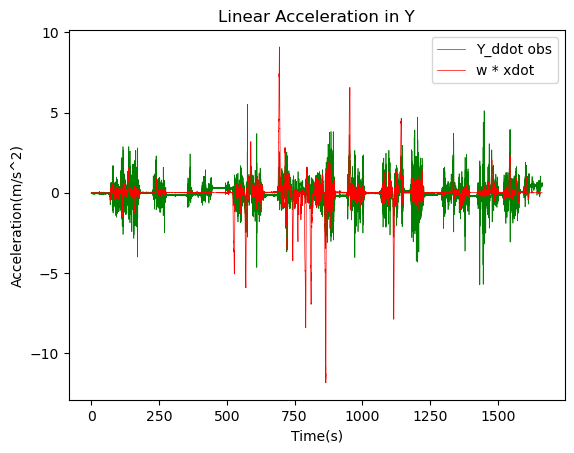

In [17]:
ts = dimu2['header.stamp.secs']
tns = dimu2['header.stamp.nsecs']
time = dimu2['Time']
time = time-min(time)

x_ddot_obs = dimu2['imu.linear_acceleration.x']

x_ddot = x_ddot_obs
bias=st.mean(x_ddot)
x_ddot= x_ddot-bias


x_dot = integrate.cumtrapz(x_ddot,time,initial = 0)
omega = dimu2['imu.angular_velocity.z']

w_xdot = omega*x_dot


y_ddot_obs = dimu2['imu.linear_acceleration.y'] 
y_ddot_obs = y_ddot_obs-np.mean(y_ddot_obs)


plt.plot(time,y_ddot_obs,label='Y_ddot obs',color='green',linewidth = 0.5)
plt.plot(time,w_xdot,label='w * xdot',color='red',linewidth = 0.5)
plt.title('Linear Acceleration in Y')
plt.xlabel('Time(s)')
plt.ylabel('Acceleration(m/s^2)')
plt.legend()
plt.show()


## Vehicle Trajectory Estimation

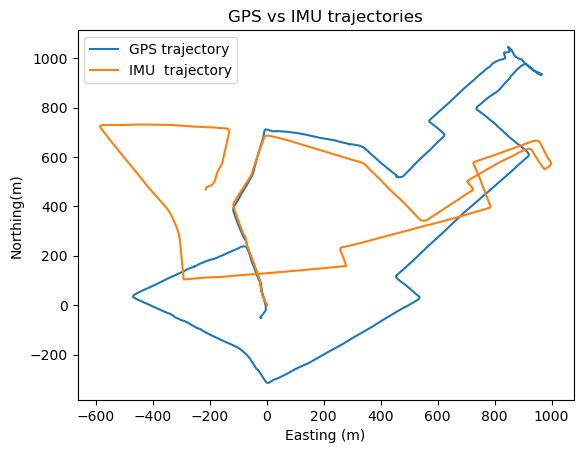

In [19]:
UTM_east = UTM_east-UTM_east[0]
UTM_north =UTM_north-UTM_north[0]

He = np.cos(YAW-(115*math.pi/180))
Hn = np.sin(YAW-(115*math.pi/180))

Ve = Hn*velocity_adjusted
Vn = He*velocity_adjusted


xe = integrate.cumtrapz(Ve,time,initial = 0)
xn = integrate.cumtrapz(Vn,time,initial = 0)


plt.plot(UTM_east,UTM_north,label='GPS trajectory')
plt.plot(xe,xn,label='IMU  trajectory')
plt.title('GPS vs IMU trajectories')
plt.xlabel('Easting (m)')
plt.ylabel('Northing(m)')
plt.legend()
plt.show()

## Xc estimation

In [18]:
omega_dot = np.diff(omega)/np.diff(time)

Xc = (-1*(w_xdot[1:]/omega_dot))
Xc = (y_ddot_obs-w_xdot)[1:]/omega_dot
#Xc = Xc[np.logical_not(np.isnan(Xc))]
#Xc=Xc.to_numpy()

Xc=Xc[np.isfinite(Xc)]
xc = np.mean(Xc)
xc


0.3488323646796743